## Pre Work
### imports, set sns style etc

In [3]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
sns.set_theme()
from pprint import pprint

from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage,cophenet
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

#Setting styles for sns
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
sns.set_style('darkgrid')

## 1.   Import Data, Initial Analysis

In [4]:
# Reading data
data = pd.read_excel('Credit Card Customer Data.xlsx')

In [5]:
data

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
0        1         87073            100000                   2   
1        2         38414             50000                   3   
2        3         17341             50000                   7   
3        4         40496             30000                   5   
4        5         47437            100000                   6   
..     ...           ...               ...                 ...   
655    656         51108             99000                  10   
656    657         60732             84000                  10   
657    658         53834            145000                   8   
658    659         80655            172000                  10   
659    660         80150            167000                   9   

     Total_visits_bank  Total_visits_online  Total_calls_made  
0                    1                    1                 0  
1                    0                   10                 9  
2                    1                    3                 4  
3                    1                    1                 4  
4                    0                   12                 3  
..                 ...                  ...               ...  
655                  1                   10                 0  
656                  1                   13                 2  
657                  1                    9                 1  
658                  1                   15                 0  
659                  0                   12                 2  

[660 rows x 7 columns]

* Data has 660 rows and 7 columns

In [6]:
data.describe().T

count          mean           std      min       25%  \
Sl_No                660.0    330.500000    190.669872      1.0    165.75   
Customer Key         660.0  55141.443939  25627.772200  11265.0  33825.25   
Avg_Credit_Limit     660.0  34574.242424  37625.487804   3000.0  10000.00   
Total_Credit_Cards   660.0      4.706061      2.167835      1.0      3.00   
Total_visits_bank    660.0      2.403030      1.631813      0.0      1.00   
Total_visits_online  660.0      2.606061      2.935724      0.0      1.00   
Total_calls_made     660.0      3.583333      2.865317      0.0      1.00   

                         50%       75%       max  
Sl_No                  330.5    495.25     660.0  
Customer Key         53874.5  77202.50   99843.0  
Avg_Credit_Limit     18000.0  48000.00  200000.0  
Total_Credit_Cards       5.0      6.00      10.0  
Total_visits_bank        2.0      4.00       5.0  
Total_visits_online      2.0      4.00      15.0  
Total_calls_made         3.0      5.00      10.0

* There is a wide spread of values between the features - min/ max for credit limit is 3k/200k
    *  for visits to bank min/ max is 0 / 5
* Will need to scale data using zscore 

In [7]:
data.isna().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

* No missing values in dataset

In [8]:
data.nunique()

Sl_No                  660
Customer Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

In [9]:
categorical_cols = list(data.columns[-4:])
pprint(categorical_cols)

['Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made']


* Sl_No has as many uniques as dataset so can be dropped
* Customer Key seems to have a few multiple entries for some customer keys - will need to investigate
* Credit Limit has a wide spread of values
* The others are more like categorical features - total credit cards, total visits, online visits and calls
    * Very few unique values 

In [10]:
# fixing column names to avoid spaces
data.columns = [c.replace(' ','_') for c in data.columns]

In [11]:
#which customer keys are repeated
x=data.Customer_Key.value_counts()
x=x[x>1]
y=x.index.tolist()
print('Customer Keys which have multiple entries in dataset are:')
pprint(y)

Customer Keys which have multiple entries in dataset are:
[50706, 37252, 97935, 96929, 47437]


In [12]:
#examining rows in data where customer key is same
for c in y:
    display(data[data.Customer_Key==c])

Sl_No  Customer_Key  Avg_Credit_Limit  Total_Credit_Cards  \
411    412         50706             44000                   4   
541    542         50706             60000                   7   

     Total_visits_bank  Total_visits_online  Total_calls_made  
411                  5                    0                 2  
541                  5                    2                 2

Sl_No  Customer_Key  Avg_Credit_Limit  Total_Credit_Cards  \
48      49         37252              6000                   4   
432    433         37252             59000                   6   

     Total_visits_bank  Total_visits_online  Total_calls_made  
48                   0                    2                 8  
432                  2                    1                 2

Sl_No  Customer_Key  Avg_Credit_Limit  Total_Credit_Cards  \
104    105         97935             17000                   2   
632    633         97935            187000                   7   

     Total_visits_bank  Total_visits_online  Total_calls_made  
104                  1                    2                10  
632                  1                    7                 0

Sl_No  Customer_Key  Avg_Credit_Limit  Total_Credit_Cards  \
391    392         96929             13000                   4   
398    399         96929             67000                   6   

     Total_visits_bank  Total_visits_online  Total_calls_made  
391                  5                    0                 0  
398                  2                    2                 2

Sl_No  Customer_Key  Avg_Credit_Limit  Total_Credit_Cards  \
4        5         47437            100000                   6   
332    333         47437             17000                   7   

     Total_visits_bank  Total_visits_online  Total_calls_made  
4                    0                   12                 3  
332                  3                    1                 0

* These duplicate entries for customer key are different row items judging by values of other columns
* We can treat these as separate rows and assume that the customer key was wrongly entered for one amongst each of the duplicate pairs as above
* In any case, we will now exclude sl_no and customer key as below so the dataset doesn't need further treatment for this assumption

In [13]:
working_df = data.iloc[:,2:] #defining working_df and not including sl_no and customer key as they dont add to our analysis

In [14]:
working_df

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0              100000                   2                  1   
1               50000                   3                  0   
2               50000                   7                  1   
3               30000                   5                  1   
4              100000                   6                  0   
..                ...                 ...                ...   
655             99000                  10                  1   
656             84000                  10                  1   
657            145000                   8                  1   
658            172000                  10                  1   
659            167000                   9                  0   

     Total_visits_online  Total_calls_made  
0                      1                 0  
1                     10                 9  
2                      3                 4  
3                      1                 4  
4                     12                 3  
..                   ...               ...  
655                   10                 0  
656                   13                 2  
657                    9                 1  
658                   15                 0  
659                   12                 2  

[660 rows x 5 columns]

* Our dataset now has 660 rows and 5 columns - all numeric

## 2.   Univariate Analysis

In [15]:
def histogram_boxplot(feature, figsize=(15,10), bins = None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    sns.boxplot(x=feature, ax=ax_box2, showmeans=True, color='violet') # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(feature, kde=False, ax=ax_hist2, bins=bins,palette="winter") if bins else sns.histplot(feature, kde=True, ax=ax_hist2) # For histogram
    ax_hist2.axvline(np.mean(feature), color='green', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-') # Add median to the histogram

def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

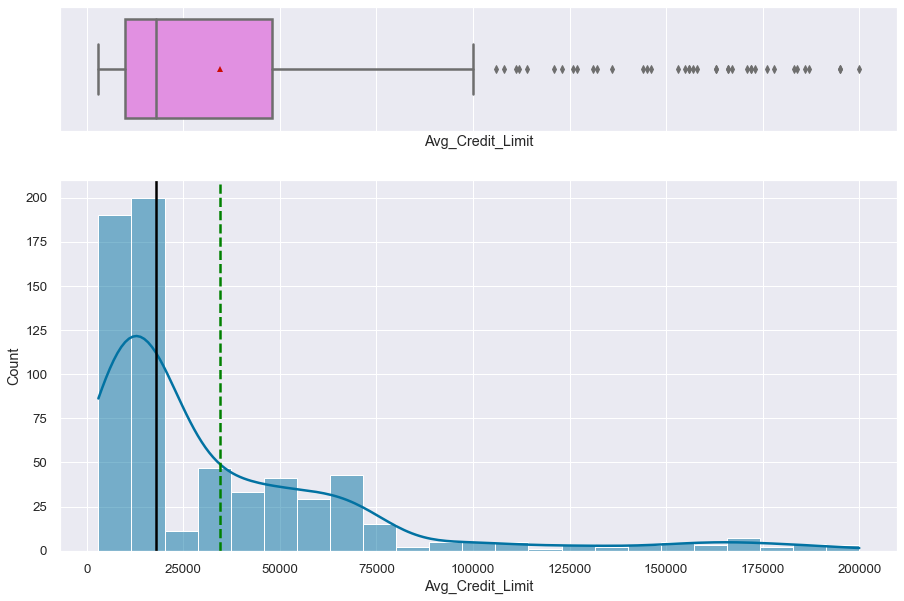

In [16]:
histogram_boxplot(working_df['Avg_Credit_Limit'])

In [17]:
#Interactive plot to hover and check outlier values, median, fences etc
px.box(working_df['Avg_Credit_Limit'], orientation='h', height=200)

<AxesSubplot:xlabel='Avg_Credit_Limit', ylabel='Proportion'>

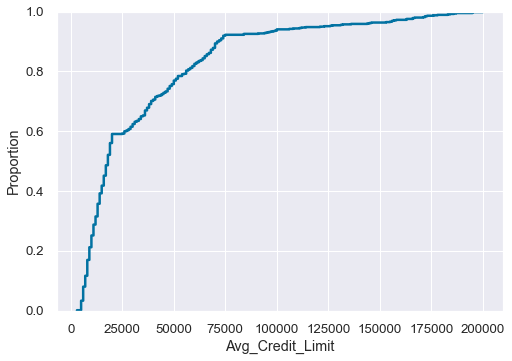

In [18]:
sns.ecdfplot(data=working_df,x='Avg_Credit_Limit')

* Avg_Credit_Limit is right skewed
    * mean is ~35000 and median is 18000 (from description used earlier)
* The boxplot upper fence is at 100,000 and there are a number of outliers beyond that too
    * However we will scale the entire dataset using zscore so we leave outliers as they are
* About 90% of customers have Avg_Credit_Limit of 75,000 or less, 60% have about 20,000 or less

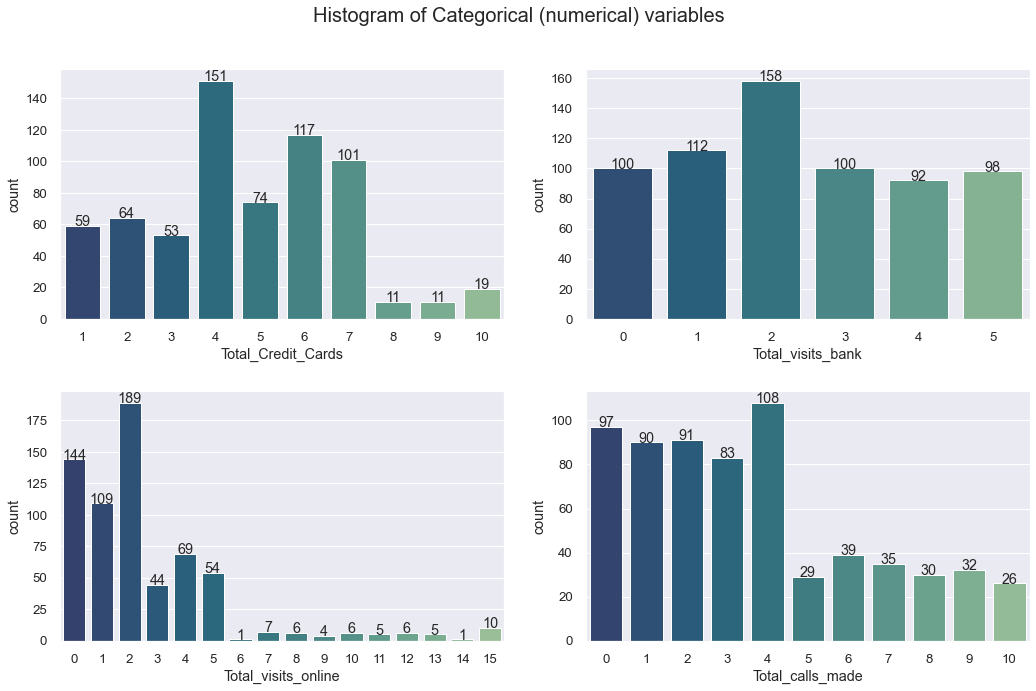

In [19]:
#all_col = working_df.iloc[:,1:].columns
fig, axes = plt.subplots(2, 2,  figsize=(15, 10))
fig.suptitle('Histogram of Categorical (numerical) variables', fontsize=20)
row = 0
for i,column in enumerate(categorical_cols):
    zz=sns.countplot(ax=axes[0 if i<2 else 1,i%2],x=working_df[column], palette='crest_r')
    show_values_on_bars(zz)
    #counter = counter+1

fig.tight_layout(pad=2.0)

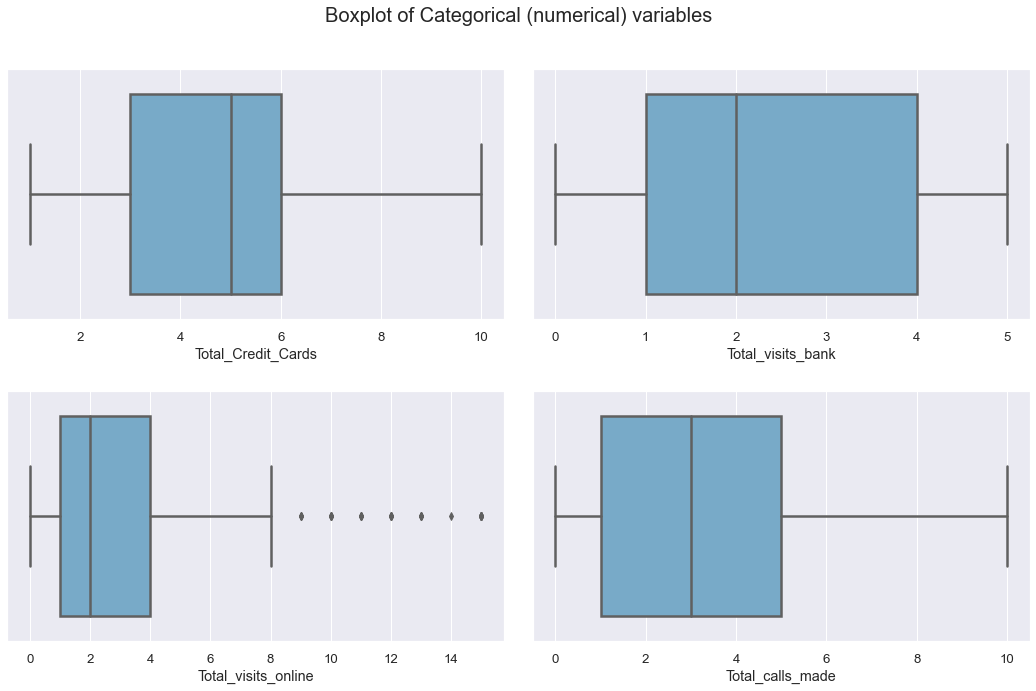

In [20]:
fig, axes = plt.subplots(2, 2,  figsize=(15, 10))
fig.suptitle('Boxplot of Categorical (numerical) variables', fontsize=20)
row = 0
for i,column in enumerate(categorical_cols):
    zz=sns.boxplot(ax=axes[0 if i<2 else 1,i%2],x=working_df[column], palette='Blues')
    show_values_on_bars(zz)
    #counter = counter+1

fig.tight_layout(pad=2.0)

In [21]:
#Interactive chart to check outliers for total visits online
px.box(working_df['Total_visits_online'], orientation='h', height=200)

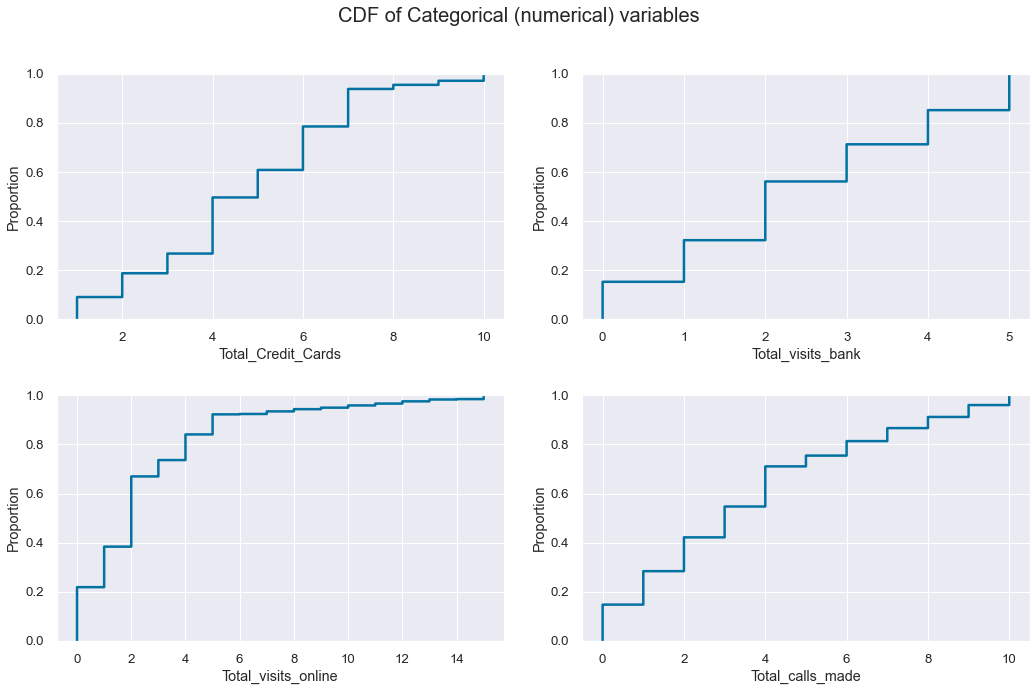

In [22]:
#Plotting CDF 
fig, axes = plt.subplots(2, 2,  figsize=(15, 10))
fig.suptitle('CDF of Categorical (numerical) variables', fontsize=20)
row = 0
for i,column in enumerate(categorical_cols):
    zz=sns.ecdfplot(ax=axes[0 if i<2 else 1,i%2],x=working_df[column], palette='Blues')
    show_values_on_bars(zz)
    #counter = counter+1

fig.tight_layout(pad=2.0)

In [23]:
# Value counts
for column in categorical_cols:
    display(working_df[column].value_counts(sort=True))

4     151
6     117
7     101
5      74
2      64
1      59
3      53
10     19
8      11
9      11
Name: Total_Credit_Cards, dtype: int64

2    158
1    112
0    100
3    100
5     98
4     92
Name: Total_visits_bank, dtype: int64

2     189
0     144
1     109
4      69
5      54
3      44
15     10
7       7
8       6
10      6
12      6
11      5
13      5
9       4
6       1
14      1
Name: Total_visits_online, dtype: int64

4     108
0      97
2      91
1      90
3      83
6      39
7      35
9      32
8      30
5      29
10     26
Name: Total_calls_made, dtype: int64

### Categorical Columns
* Total_Credit_Cards: 
    * About 50% of the data set have 4 credit cards
    * ~80% have 6 or fewer cards and ~95% have 7 or fewer
    * mean/ median for this column is 4.7 and 5 and min/ max is 1 and 10
* Total_visits_bank
    * About 15% have never visited the bank
    * ~85% have made 4 or fewer visits
    * mean/ median for this column is 2.4 and 2 and min/ max is 0 and 5
* Total_visits_online
    * Slightly more than 20% have never made online visits
    * About 92% have made 5 or fewer visits
    * mean/ median for this column is 2.6 and 2 and min/ max is 0 and 15
* Total_calls_made
    * About 55% have made 5 or fewer calls; about 15% have never called
    * About 905 have made 8 or fewer calls
    * IQR upper fence is 8 and points beyond that are outliers - however, we will scale the entire dataset to zscore so we leave it as it is
    * * mean/ median for this column is 3.6 and 3 and min/ max is 0 and 10

## 3.   Bivariate Analysis

<AxesSubplot:>

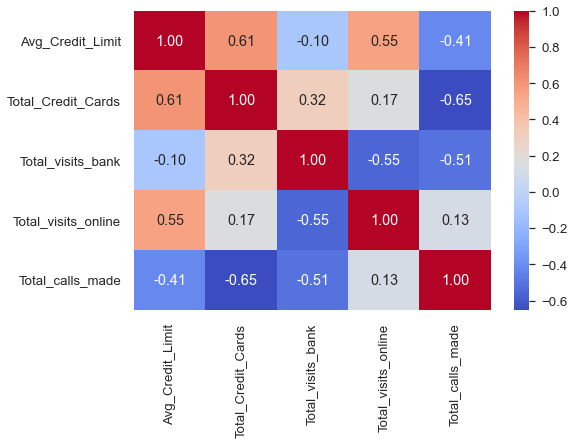

In [24]:
sns.heatmap(working_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')

* There aren't very strong correlations here - however:
    * Avg_Credit_Limit and Total_Credit_Cards have positive correlation of 0.6 - this makes sense since higher spending power/ more credit worthy customers would likely have more cards
    * Avg_Credit_Limit and Total_visits_online have a 0.55 positive correlation
    * Total_calls_made has a negative corr with Total_Credit_Cards of -0.65 
    * Total_calls_made has a negative corr of -0.51 with Total_visits_bank which makes sense as those who call in would likely not need to make as many physical visits
    * Total_visits_online has a negative corr of -0.55 with Total_visits_bank which makes sense as those who call in would likely not need to make as many physical visits


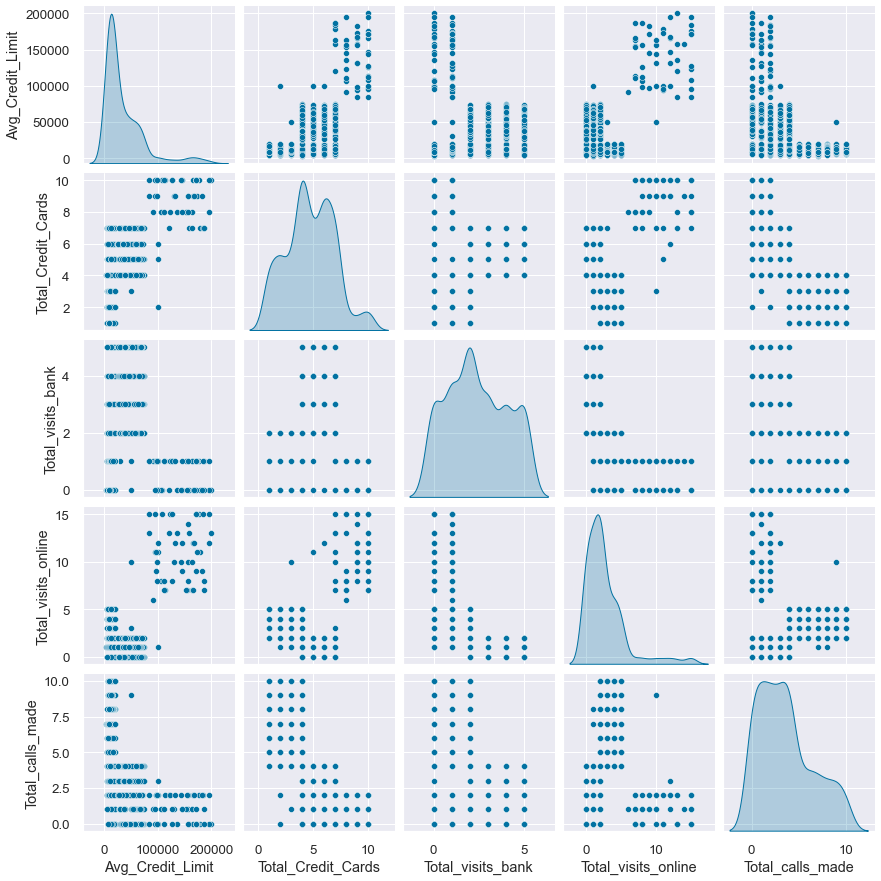

In [25]:
sns.pairplot(working_df, diag_kind='kde',palette='Blues')

* credit limit, calls made and visits online are right skewed
* total credit cards and total visits are more symmetric
* looking at the peaks in the kde's for total credit cards and visits there might be 4-6 clusters; however looking at others, 3 is also a possibility - will consider 3 - 6 clusters in modelling


## 4. Modelling 

### 4a. Scaling Data - this is important for clustering algorithms as otherwise columns with larger scales will dominate the clustering (since clustering is a distance based algorithm)

In [26]:
#setting random_state 
random_state = 314159

In [27]:
# Scaling the data set before clustering
scaler=StandardScaler()
#wo=working_df.copy()
scaled_data=scaler.fit_transform(working_df)

In [28]:
df_scaled = pd.DataFrame(scaled_data, columns = working_df.columns)
df_scaled

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0            1.740187           -1.249225          -0.860451   
1            0.410293           -0.787585          -1.473731   
2            0.410293            1.058973          -0.860451   
3           -0.121665            0.135694          -0.860451   
4            1.740187            0.597334          -1.473731   
..                ...                 ...                ...   
655          1.713589            2.443892          -0.860451   
656          1.314621            2.443892          -0.860451   
657          2.937092            1.520613          -0.860451   
658          3.655235            2.443892          -0.860451   
659          3.522245            1.982253          -1.473731   

     Total_visits_online  Total_calls_made  
0              -0.547490         -1.251537  
1               2.520519          1.891859  
2               0.134290          0.145528  
3              -0.547490          0.145528  
4               3.202298         -0.203739  
..                   ...               ...  
655             2.520519         -1.251537  
656             3.543188         -0.553005  
657             2.179629         -0.902271  
658             4.224968         -1.251537  
659             3.202298         -0.553005  

[660 rows x 5 columns]

In [29]:
df_scaled.describe()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
count      6.600000e+02        6.600000e+02       6.600000e+02   
mean       8.612639e-17        4.306320e-17      -4.306320e-17   
std        1.000758e+00        1.000758e+00       1.000758e+00   
min       -8.398081e-01       -1.710864e+00      -1.473731e+00   
25%       -6.536229e-01       -7.875852e-01      -8.604506e-01   
50%       -4.408398e-01        1.356941e-01      -2.471705e-01   
75%        3.570968e-01        5.973337e-01       9.793898e-01   
max        4.399975e+00        2.443892e+00       1.592670e+00   

       Total_visits_online  Total_calls_made  
count         6.600000e+02      6.600000e+02  
mean          7.536059e-17     -8.612639e-17  
std           1.000758e+00      1.000758e+00  
min          -8.883795e-01     -1.251537e+00  
25%          -5.474897e-01     -9.022711e-01  
50%          -2.065999e-01     -2.037386e-01  
75%           4.751797e-01      4.947938e-01  
max           4.224968e+00      2.241125e+00

* All data is now scaled using zscores

### 4b. K Means clustering

In [30]:
clusters=range(1,9) # Although EDA shows likely 3-6 clusters we explore 1-8 (also needed for visualisations below)
meanDistortions=[]
predictions = {}

for k in clusters:
    model=KMeans(n_clusters=k, random_state=random_state) #declare model with k clusters
    model.fit(df_scaled) #fit model to scaled data
    prediction=model.predict(df_scaled) #make predictions of clusters based on scaled data
    predictions[k] = prediction
    #print(np.min(cdist(df_scaled, model.cluster_centers_, 'euclidean'), axis=1).shape)
    #Next we compute the distorition ie euclidean distance (variance) within each cluster 
    #cdist finds distances between two matrices - we use euclidean which is passed as parameter
    #the output contains the distance of each row from each centroid 
    #since we need only within cluster variance, we use np.min to select the minimum for each row which
    #of course is its own cluster centroid
    #this is then divided by no of rows to convert to variance
    distortion=sum(np.min(cdist(df_scaled, model.cluster_centers_, 'euclidean'), axis=1)) / df_scaled.shape[0]
                           
    meanDistortions.append(distortion)
    
    print(f'Number of Clusters: {k} \t Average Distortion: {distortion:.3f}')



Number of Clusters: 1 	 Average Distortion: 2.007
Number of Clusters: 2 	 Average Distortion: 1.457
Number of Clusters: 3 	 Average Distortion: 1.147
Number of Clusters: 4 	 Average Distortion: 1.046
Number of Clusters: 5 	 Average Distortion: 0.991
Number of Clusters: 6 	 Average Distortion: 0.943
Number of Clusters: 7 	 Average Distortion: 0.923
Number of Clusters: 8 	 Average Distortion: 0.889


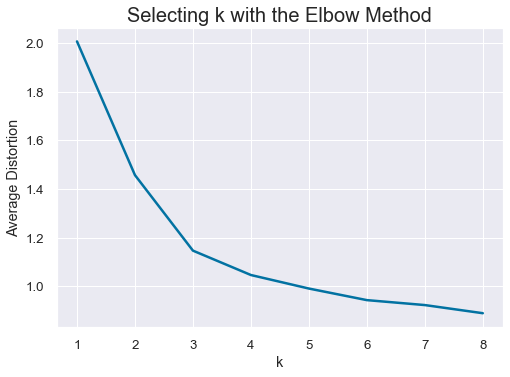

In [31]:
#Plotting elbow plot
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
sns.lineplot(x=clusters, y=meanDistortions)
plt.xlabel('k')
plt.ylabel('Average Distortion')
plt.title('Selecting k with the Elbow Method', fontsize=20);

* We see a sharp elbow at 3 which is likely the appropriate no of clusters for this dataset
* Will examine this with silhouette scores


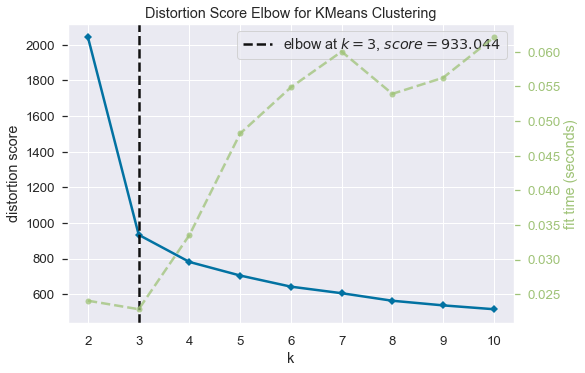

In [32]:
#Using alternative yellowbrick elbow visualiser
visualizer = KElbowVisualizer(KMeans(random_state = random_state))

visualizer.fit(df_scaled)        # Fit the data to the visualizer
visualizer.show();

In [33]:
# Computing Silhouette scores
sil_score = []
cluster_list = list(range(2,9))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters, random_state=random_state)
    preds = clusterer.fit_predict(df_scaled)
    #centers = clusterer.cluster_centers_
    score = silhouette_score(df_scaled, preds, random_state=random_state)
    sil_score.append(score)
    print(f"For n_clusters = {n_clusters}, silhouette score is {score:.3f})")

For n_clusters = 2, silhouette score is 0.418)
For n_clusters = 3, silhouette score is 0.516)
For n_clusters = 4, silhouette score is 0.356)
For n_clusters = 5, silhouette score is 0.273)
For n_clusters = 6, silhouette score is 0.255)
For n_clusters = 7, silhouette score is 0.235)
For n_clusters = 8, silhouette score is 0.227)


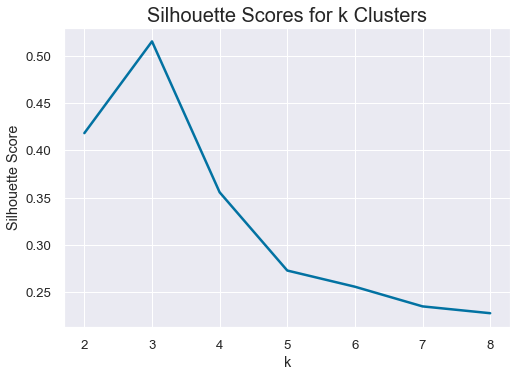

In [34]:
sns.lineplot(x=cluster_list,y=sil_score)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for k Clusters', fontsize=20);

* Here again we see for 3 clusters, silhouette score is highest at 0.5157
* Higher silhouette score means each point is well contained in its cluster and is far away from other clusters

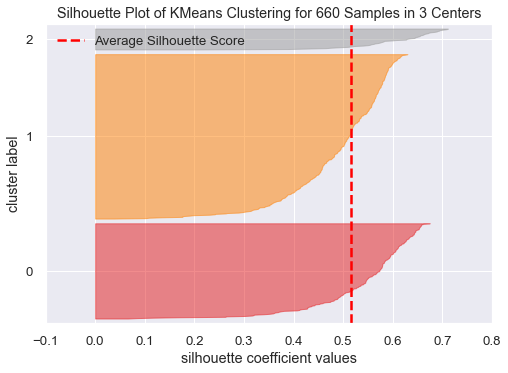

In [35]:

# Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state = random_state))
visualizer.fit(df_scaled)    
visualizer.show();

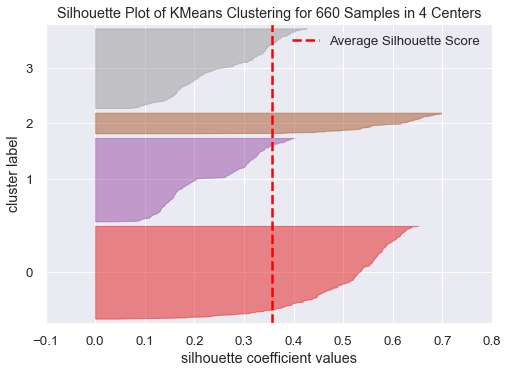

In [36]:
# Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state = random_state))
visualizer.fit(df_scaled)    
visualizer.show();

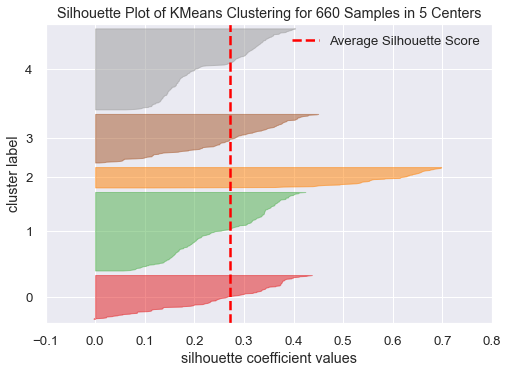

In [37]:
# Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state = random_state))
visualizer.fit(df_scaled)    
visualizer.show();

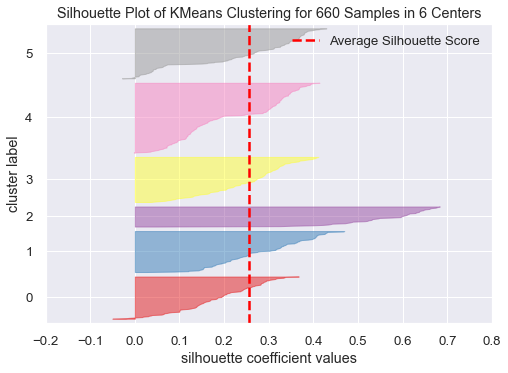

In [38]:
# Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(6, random_state = random_state))
visualizer.fit(df_scaled)    
visualizer.show();

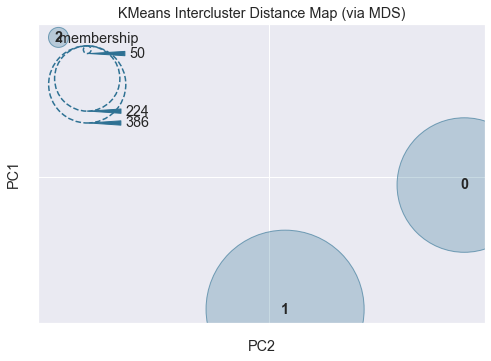

In [39]:
#Using yellowbrick visualiser to check cluster dispersion
'''from the docs: Intercluster distance maps display an embedding of the cluster centers in 2 dimensions with the distance to other centers preserved. E.g. the closer to centers are in the visualization, the closer they are in the original feature space. The clusters are sized according to a scoring metric. By default, they are sized by membership, e.g. the number of instances that belong to each center. This gives a sense of the relative importance of clusters. Note however, that because two clusters overlap in the 2D space, it does not imply that they overlap in the original feature space.'''

visualizer = InterclusterDistance(KMeans(3, random_state = random_state),legend_loc='upper left')

visualizer.fit(df_scaled)        # Fit the data to the visualizer
visualizer.show();

* Based on the silhouette visualisations, we see that the scores are very widely dispersed for 4,5,6 clusters whereas for 3 clusters, the silhouette scores for all clusters are about the same - this indicates good fit
* However we do see that all clusters are not the same size and the 2nd cluster has very many points while the third cluster has few rows in it

In [40]:
#Adding a column to working_df with the predictions from our kmeans model where n_clusters = 3
working_df = working_df.assign(kmeans_clusters = predictions[3])
working_df

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0              100000                   2                  1   
1               50000                   3                  0   
2               50000                   7                  1   
3               30000                   5                  1   
4              100000                   6                  0   
..                ...                 ...                ...   
655             99000                  10                  1   
656             84000                  10                  1   
657            145000                   8                  1   
658            172000                  10                  1   
659            167000                   9                  0   

     Total_visits_online  Total_calls_made  kmeans_clusters  
0                      1                 0                1  
1                     10                 9                0  
2                      3                 4                1  
3                      1                 4                1  
4                     12                 3                2  
..                   ...               ...              ...  
655                   10                 0                2  
656                   13                 2                2  
657                    9                 1                2  
658                   15                 0                2  
659                   12                 2                2  

[660 rows x 6 columns]

In [41]:
working_df.groupby('kmeans_clusters').mean()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
kmeans_clusters                                                            
0                    12174.107143            2.410714           0.933036   
1                    33782.383420            5.515544           3.489637   
2                   141040.000000            8.740000           0.600000   

                 Total_visits_online  Total_calls_made  
kmeans_clusters                                         
0                           3.553571          6.870536  
1                           0.981865          2.000000  
2                          10.900000          1.080000

In [42]:
working_df.groupby('kmeans_clusters').count()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
kmeans_clusters                                                            
0                             224                 224                224   
1                             386                 386                386   
2                              50                  50                 50   

                 Total_visits_online  Total_calls_made  
kmeans_clusters                                         
0                                224               224  
1                                386               386  
2                                 50                50

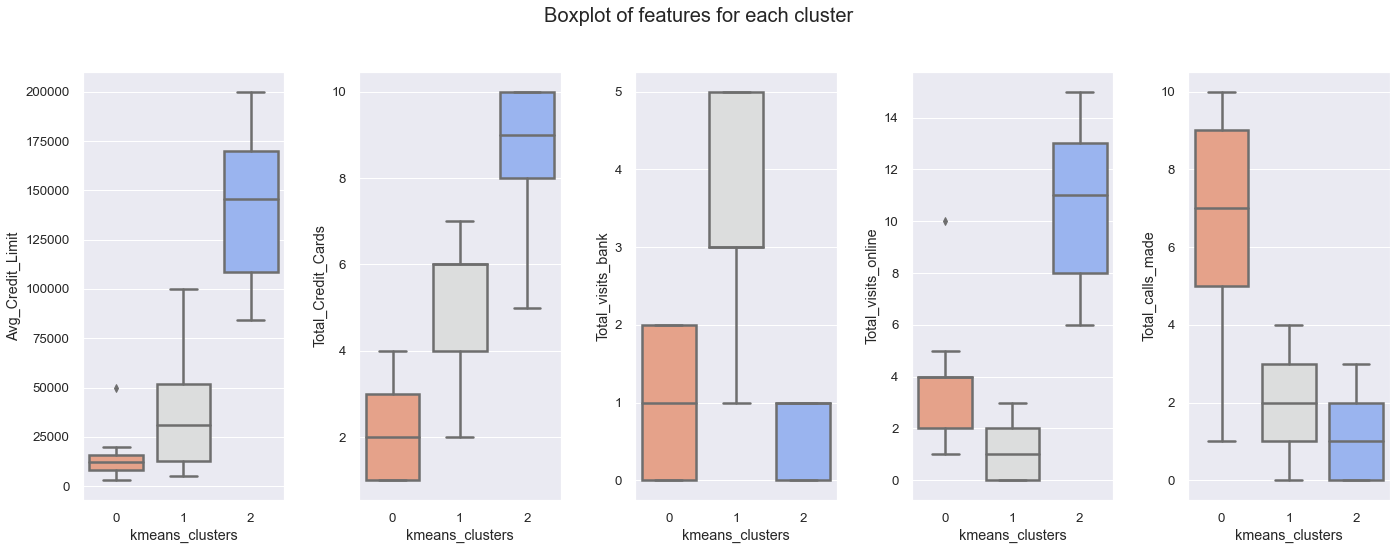

In [43]:
fig, axes = plt.subplots(1, 5,  figsize=(20, 8))
fig.suptitle('Boxplot of features for each cluster', fontsize=20)
counter = 0
for i,column in enumerate(working_df.columns[:-1]):
    sns.boxplot(ax=axes[i],y=working_df[column],x=working_df.kmeans_clusters, palette='coolwarm_r')
    

fig.tight_layout(pad=2.0)

### Cluster Characteristics:
* Cluster 0:
    * Avg. credit limit of 12174
    * Have 2.4 credit cards on Avg
    * Made 1 visit to bank, 3.6 online visits and 6.9 calls
    * This cluster has likely lower income people since credit limit and no of cards is lower than other clusters
    * They are most likely to call in to the bank rather than visit online or physically
    * 224 rows in this cluster
* Cluster 1:
    * Avg. credit limit of 33782
    * Have 5.5 credit cards on Avg
    * Made 3.5 visit to bank, 1 online visits and 2 calls
    * This cluster is likely customers who have spending power between the other two clusters as credit limit and no of cards is more than in cluster 0 but less than cluster 2
    * These customers are most likely to make physical visits to the bank
    * 386 rows in this cluster
* Cluster 2:
    * Avg. credit limit of 141040
    * Have 8.7 credit cards on Avg
    * Made .6 visit to bank, 10.9 online visits and 1.1 calls
    * These are liekly high networth individuals as the mean credit limit is significantly higher than the other two clusters and they also own more credit cards
    * These customers are more likely to make online visits
* The clusters seem quite distinct and it appears the model works well in segregating the dataset into unique and distinct groups with their own behaviour characteristics
    * Based on the above, the bank would be well served to tune the delivery channels (physical, online, call) to the needs of each cluster - customers can be grouped by credit limit and cards

### 4c. Hierarchical Clustering

* First we check for best cophenetic coeff amongst the following methods and metrics

In [44]:
def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    source: https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)


In [45]:
# cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram
# closer it is to 1, the better is the clustering

#since there are outliers, it is good practice to check distnce metrics other than eculidean which doesnt handle outliers as well as the others. Mahalanobis is esp used for outlier cases
distance_metrics = [ 'euclidean','chebyshev','mahalanobis','cityblock'] 

#The following linkage methods work for all metrics listed above
linkage_methods = ['single', 'complete', 'average', 'weighted']

corrs=[] 
corr_d = {}

for dm in distance_metrics:
    
    corrs=[]
    for lm in linkage_methods:
        Z = linkage(df_scaled, metric=dm, method=lm)
        c, coph_dists = cophenet(Z , pdist(df_scaled))
        corrs.append(c)

    corr_d[dm] = corrs


corr_df = pd.DataFrame.from_dict(corr_d, orient='index', columns=linkage_methods)
max_method=corr_df.max().idxmax()
max_metric=corr_df[max_method].idxmax()
max_corr = corr_df.loc[max_metric,max_method]



print("Cophenetic coeff for methods and metrics are:")
#corr_df.style.apply(highlight_max, color='darkorange', axis=None)

display(corr_df.style.apply(highlight_max, color='darkorange', axis=None))
print(f'\nMax value of coeff is {max_corr:.5f} which is for metric: {max_metric} and method: {max_method}')

Cophenetic coeff for methods and metrics are:



Max value of coeff is 0.89771 which is for metric: euclidean and method: average


* We see that the best fit tree (determined by the highest cophenetic coeff is for the euclidean metric with average method

### Now we check cophenetic for median, ward and centroid which only work with metric = euclidean

In [46]:
linkage_methods = ['single', 'complete', 'average','median','ward', 'weighted', 'centroid']

corrs=[]
corr_d2 = {}

for lm in linkage_methods:
    Z = linkage(df_scaled, metric='euclidean', method=lm)
    c, coph_dists = cophenet(Z , pdist(df_scaled))
    corrs.append(c)

corr_d2['euclidean'] = corrs


corr_df2 = pd.DataFrame.from_dict(corr_d2, orient='index',columns=linkage_methods)
max_method2=corr_df2.max().idxmax()
max_metric2=corr_df2[max_method].idxmax()
max_corr2 = corr_df2.loc[max_metric,max_method]

print("Cophenetic coeff for methods and metrics are:")
display(corr_df2.style.apply(highlight_max, color='darkorange', axis=None))
print(f'\nMax value of coeff is {max_corr2:.6f} which is for metric: {max_metric2} and method: {max_method2}')
    

Cophenetic coeff for methods and metrics are:



Max value of coeff is 0.897708 which is for metric: euclidean and method: average


* We see that across all the methods and metrics evaluated, the best cophenetic correlation is for euclidean with average linkage method

### Evaluating various dendogram structures for euclidean

CPU times: user 6.87 s, sys: 323 ms, total: 7.19 s
Wall time: 5.87 s


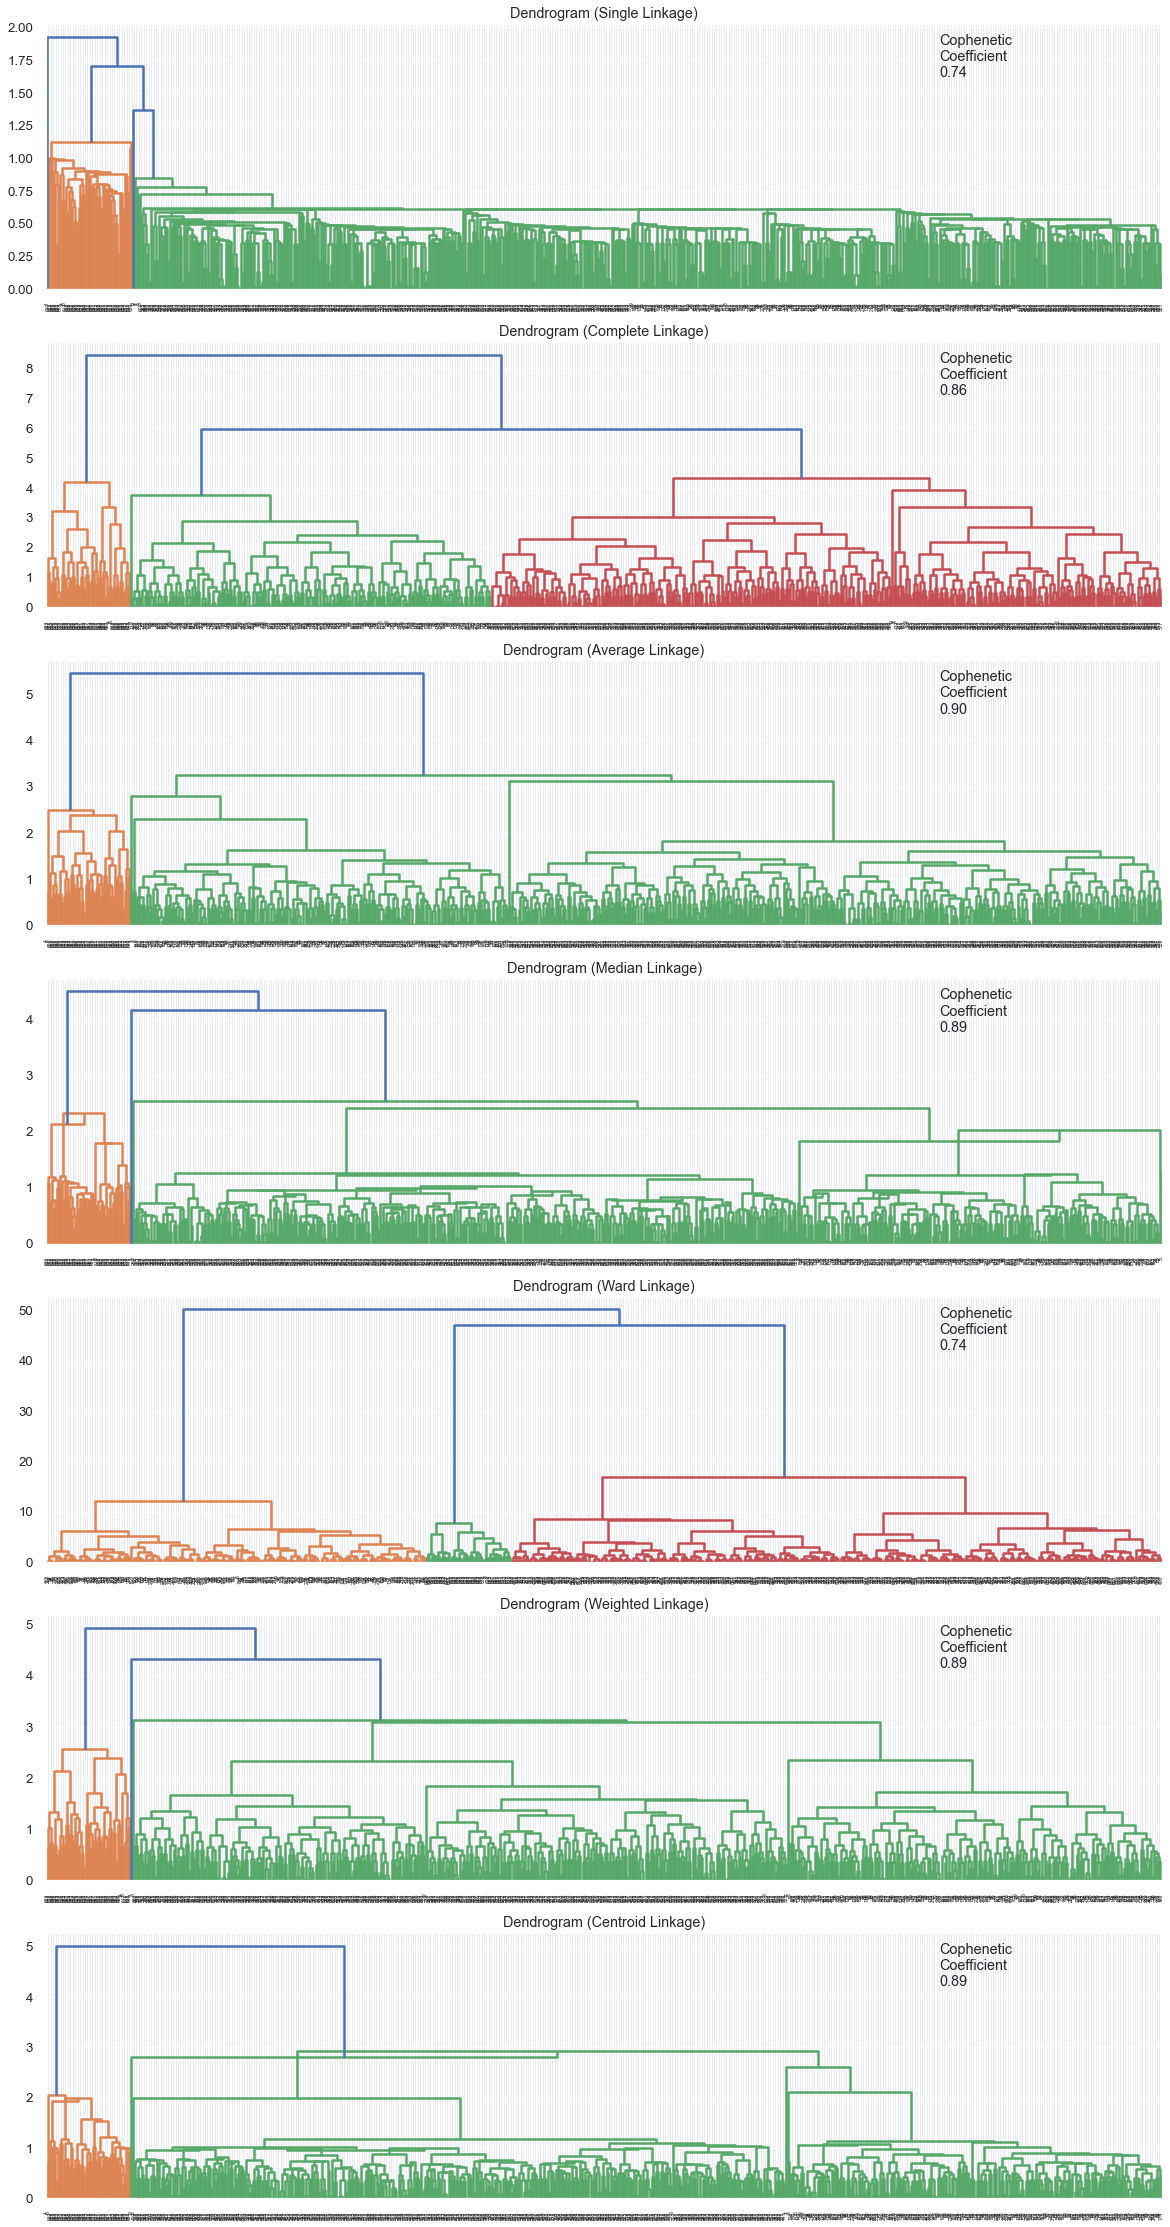

In [146]:
%%time


# Create lists to save results of coph calculation
compare_cols = ['Linkage', 'Cophenetic Coefficient']
compare = []

# Create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(20, 40))

# Enumerate through the list of all methods above
# Get linkage, plot dendrogram, calculate cophenetic coefficient
for i, method in enumerate(linkage_methods):
    
    Z = linkage(df_scaled, metric='euclidean', method=method)

    dendrogram(Z, ax=axs[i]);
    axs[i].set_title(f'Dendrogram ({method.capitalize()} Linkage)')
    coph_corr, coph_dist = cophenet(Z, pdist(df_scaled))
    axs[i].annotate(f'Cophenetic\nCoefficient\n{coph_corr:0.2f}', 
                    (0.80, 0.80),
                    xycoords='axes fraction')
    compare.append([method, coph_corr])

* The average method yields clear clusters at k =3
* none of the methods yield clusters of 3-5 size which are balanced in size - indicates that the clusters present in data are imbalanced and this is not an issue with our clustering modelling

In [148]:
#Examining silhouette scores for various values of n_clusters
silscores = {}
for i in range(2,10):
    HCmodel = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='average')
    HCmodel.fit(df_scaled)
    silscores[i] = silhouette_score(df_scaled,HCmodel.labels_)

print("silhouette scores for agglomerative clustering with various values of n_clusters are:")
silscores

silhouette scores for agglomerative clustering with various values of n_clusters are:


{2: 0.5703183487340514,
 3: 0.515922432650965,
 4: 0.47495143595793504,
 5: 0.44039753024783956,
 6: 0.4153547954831452,
 7: 0.4183775674672025,
 8: 0.34306710358280806,
 9: 0.3415486932890892}

* Silhouette score is better when close to +1 - 0.5159 is a decent outcome for k=3
    * Very similar to the Silhouette score generated by kmeans
    * however, for k=2, it shows an even higher Silhouette score of 0.57 - need to check using othr methods which is better between k=2 or 3

In [370]:
#Defining a child class to AgglomerativeClustering which has a predict method (needed by yellowbrick visualiser)
class AgglomerativeClusteringWithPredict(AgglomerativeClustering):
    def __init__(self, fname, lname):
        super().__init__(fname, lname) 

    def __init__(self, n_clusters, affinity, linkage):
        super().__init__(n_clusters, affinity=affinity, linkage=linkage)

    def predict(self, data):
        self.labels_ = super().fit_predict(data)
    
    def makeClusterCenterList(self):
        temp=[]
        #print(self.df.columns)
        for a in set(self.labels_):
            #print(a)
            x = self.df[self.df['AgglomerativeClusteringWithPredictLabels']==a].mean(axis=0)
            #print(x[:-1])
            temp.append(list(x[:-1]))
        del(self.df)
        self.cluster_centers_ = np.array(temp)

    def fit_predict(self, df):
        self.labels_ = super().fit_predict(df)
        self.df = df.copy()
        self.df['AgglomerativeClusteringWithPredictLabels'] = self.labels_
        self.makeClusterCenterList()

    df = pd.DataFrame()
    cluster_centers_ = []
    labels_ = []

In [371]:
x=AgglomerativeClusteringWithPredict(n_clusters=3,affinity='euclidean', linkage='average')
x.fit_predict(df_scaled)
x.cluster_centers_


array([[-0.02290249,  0.37188177,  0.66403387, -0.55277481, -0.55119989],
       [ 2.83176409,  1.86222621, -1.10576269,  2.82731942, -0.87432983],
       [-0.59517911, -1.06291281, -0.90445279,  0.32537166,  1.1526047 ]])

In [372]:
modelmodelmodel.cluster_centers_

array([[-0.02106178,  0.37368962,  0.6663945 , -0.55367163, -0.55300488],
       [-0.59579625, -1.05962278, -0.9015185 ,  0.32299678,  1.14810882],
       [ 2.83176409,  1.86222621, -1.10576269,  2.82731942, -0.87432983]])

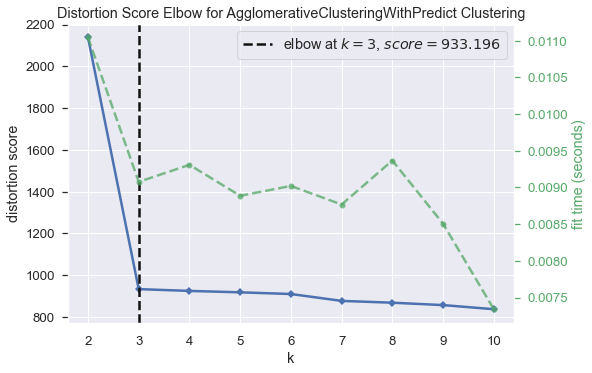

In [374]:
visualizer = KElbowVisualizer(AgglomerativeClusteringWithPredict(n_clusters=None,affinity='euclidean', linkage='average'))

visualizer.fit(df_scaled)        # Fit the data to the visualizer
visualizer.show();

* Yellowbrick elbow visualizer found an elbow at k = 3
* while the silhouette score for k=3 is less than that for k=2, k=3 also matches what we found with kmeans and so we use k=3 for our analysis

In [1]:

#Adding cluster labels as a column in the df

HCmodel = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='average')
HCmodel.fit(df_scaled)
working_df['hc_clusters'] = HCmodel.labels_

NameError: name 'AgglomerativeClustering' is not defined

In [2]:
T.shape

NameError: name 'T' is not defined

In [157]:
T=HCmodel.labels_

lens = {}      # will contain the lengths for each cluster
centroids = {} # will contain the centroids of each cluster
for idx,clno in enumerate(T):
    centroids.setdefault(clno,np.zeros(5)) 
    centroids[clno] += features[idx,:]
    lens.setdefault(clno,0)
    lens[clno] += 1
# Divide by number of observations in each cluster to get the centroid
for clno in centroids:
    centroids[clno] /= float(lens[clno])

NameError: name 'features' is not defined

In [74]:
working_df

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0              100000                   2                  1   
1               50000                   3                  0   
2               50000                   7                  1   
3               30000                   5                  1   
4              100000                   6                  0   
..                ...                 ...                ...   
655             99000                  10                  1   
656             84000                  10                  1   
657            145000                   8                  1   
658            172000                  10                  1   
659            167000                   9                  0   

     Total_visits_online  Total_calls_made  kmeans_clusters  hc_clusters  
0                      1                 0                1            0  
1                     10                 9                0            2  
2                      3                 4                1            0  
3                      1                 4                1            0  
4                     12                 3                2            1  
..                   ...               ...              ...          ...  
655                   10                 0                2            1  
656                   13                 2                2            1  
657                    9                 1                2            1  
658                   15                 0                2            1  
659                   12                 2                2            1  

[660 rows x 7 columns]

In [75]:
working_df.groupby('hc_clusters').mean()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
hc_clusters                                                            
0                33713.178295            5.511628           3.485788   
1               141040.000000            8.740000           0.600000   
2                12197.309417            2.403587           0.928251   

             Total_visits_online  Total_calls_made  kmeans_clusters  
hc_clusters                                                          
0                       0.984496          2.005168         0.997416  
1                      10.900000          1.080000         2.000000  
2                       3.560538          6.883408         0.000000

In [76]:
working_df.groupby('hc_clusters').count()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
hc_clusters                                                            
0                         387                 387                387   
1                          50                  50                 50   
2                         223                 223                223   

             Total_visits_online  Total_calls_made  kmeans_clusters  
hc_clusters                                                          
0                            387               387              387  
1                             50                50               50  
2                            223               223              223

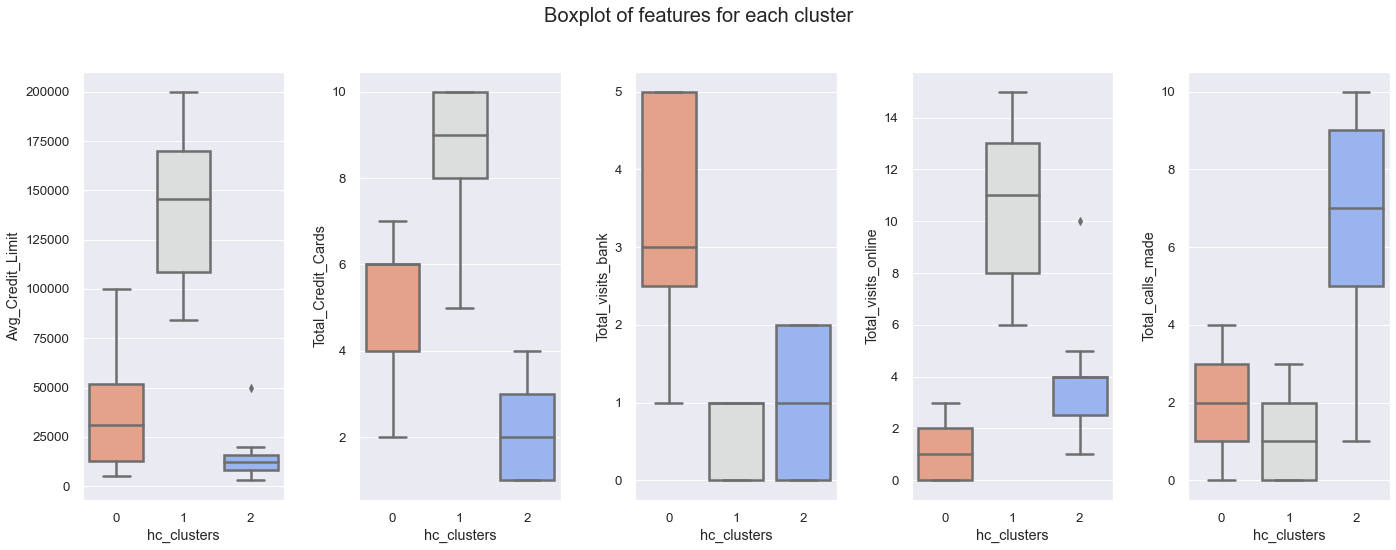

In [77]:
fig, axes = plt.subplots(1, 5,  figsize=(20, 8))
fig.suptitle('Boxplot of features for each cluster', fontsize=20)
counter = 0
for i,column in enumerate(working_df.columns[:-2]):
    sns.boxplot(ax=axes[i],y=working_df[column],x=working_df.hc_clusters, palette='coolwarm_r')
    

fig.tight_layout(pad=2.0)

* These clusters are very similar to the ones from k means (except are labelled differently)
* Will compare more closely with k means after relabeling so as to have same cluster names


In [78]:
#Lets relabel Heirarchical clusters to better compare to kmeans
working_df['hc_clusters_relabel'] = working_df['hc_clusters'].map(lambda x: (x+1)%3)

In [79]:
mod2 = AgglomerativeClusteringWithPredict(n_clusters=3,affinity='euclidean', linkage='average')
x=mod2.predict(df_scaled)
y=HCmodel.fit_predict(df_scaled)
print(f'Making sure that predictions returned by my custom class are the same as those returned by the parent class: {sum(x==y)==working_df.shape[0]}')
#working_df['HC_Clusters'] = HCmodel.labels_

Making sure that predictions returned by my custom class are the same as those returned by the parent class: True


In [80]:
working_df

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0              100000                   2                  1   
1               50000                   3                  0   
2               50000                   7                  1   
3               30000                   5                  1   
4              100000                   6                  0   
..                ...                 ...                ...   
655             99000                  10                  1   
656             84000                  10                  1   
657            145000                   8                  1   
658            172000                  10                  1   
659            167000                   9                  0   

     Total_visits_online  Total_calls_made  kmeans_clusters  hc_clusters  \
0                      1                 0                1            0   
1                     10                 9                0            2   
2                      3                 4                1            0   
3                      1                 4                1            0   
4                     12                 3                2            1   
..                   ...               ...              ...          ...   
655                   10                 0                2            1   
656                   13                 2                2            1   
657                    9                 1                2            1   
658                   15                 0                2            1   
659                   12                 2                2            1   

     hc_clusters_relabel  
0                      1  
1                      0  
2                      1  
3                      1  
4                      2  
..                   ...  
655                    2  
656                    2  
657                    2  
658                    2  
659                    2  

[660 rows x 8 columns]

In [81]:
(working_df.hc_clusters_relabel==working_df.kmeans_clusters).value_counts()

True     659
False      1
dtype: int64

* only one row is differently grouped by kmeans and HC - that row is as below:

In [83]:
working_df[working_df.hc_clusters_relabel!=working_df.kmeans_clusters]

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
313              7000                   4                  2   

     Total_visits_online  Total_calls_made  kmeans_clusters  hc_clusters  \
313                    2                 4                0            0   

     hc_clusters_relabel  
313                    1

In [84]:
display(working_df.groupby('kmeans_clusters').mean().iloc[:,:-2])
display(working_df.groupby('hc_clusters_relabel').mean().iloc[:,:-2])

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
kmeans_clusters                                                            
0                    12174.107143            2.410714           0.933036   
1                    33782.383420            5.515544           3.489637   
2                   141040.000000            8.740000           0.600000   

                 Total_visits_online  Total_calls_made  
kmeans_clusters                                         
0                           3.553571          6.870536  
1                           0.981865          2.000000  
2                          10.900000          1.080000

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
hc_clusters_relabel                                                            
0                        12197.309417            2.403587           0.928251   
1                        33713.178295            5.511628           3.485788   
2                       141040.000000            8.740000           0.600000   

                     Total_visits_online  Total_calls_made  
hc_clusters_relabel                                         
0                               3.560538          6.883408  
1                               0.984496          2.005168  
2                              10.900000          1.080000

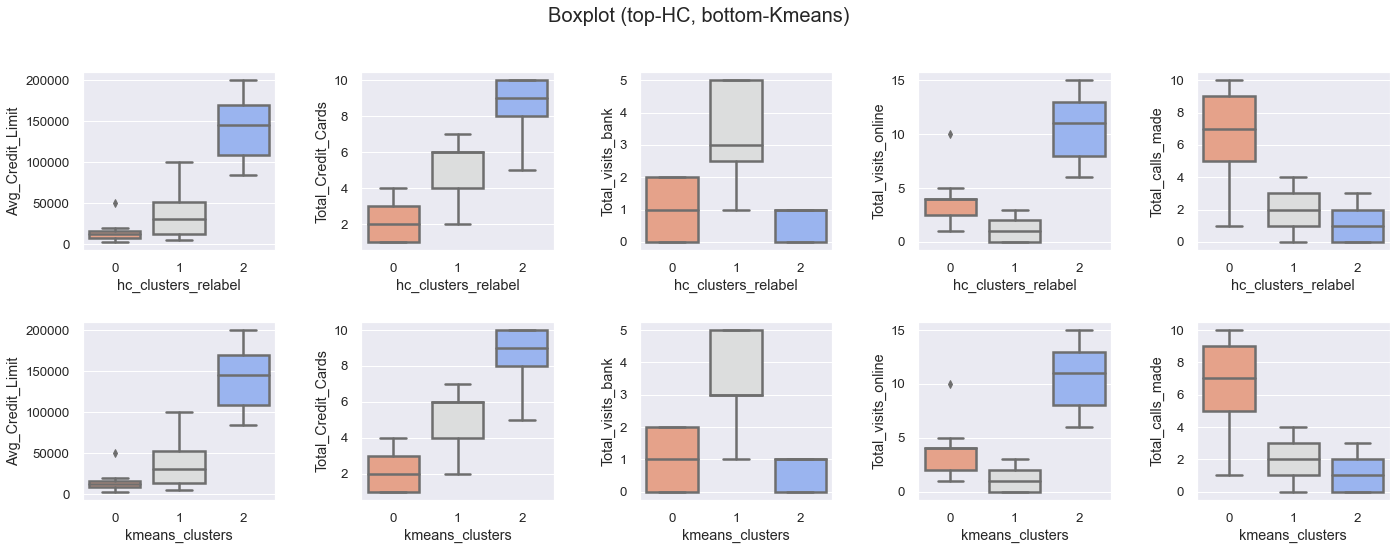

In [85]:
fig, axes = plt.subplots(2, 5,  figsize=(20, 8))
fig.suptitle('Boxplot (top-HC, bottom-Kmeans)', fontsize=20)
counter = 0
for i,column in enumerate(working_df.columns[:-3]):
    sns.boxplot(ax=axes[0,i],y=working_df[column],x=working_df.hc_clusters_relabel, palette='coolwarm_r')
    sns.boxplot(ax=axes[1,i],y=working_df[column],x=working_df.kmeans_clusters, palette='coolwarm_r')
    

fig.tight_layout(pad=2.0)

* Clusters generated by both methods are nearly identical
    * only one row is differently clustered
    * analysis and recommendations based on kmeans and heirarchical is therefore the same

### Cluster Characteristics:
* Cluster 0:
    * Avg. credit limit of 12174
    * Have 2.4 credit cards on Avg
    * Made 1 visit to bank, 3.6 online visits and 6.9 calls
    * This cluster has likely lower income people since credit limit and no of cards is lower than other clusters
    * They are most likely to call in to the bank rather than visit online or physically
    * 224 rows in this cluster
* Cluster 1:
    * Avg. credit limit of 33782
    * Have 5.5 credit cards on Avg
    * Made 3.5 visit to bank, 1 online visits and 2 calls
    * This cluster is likely customers who have spending power between the other two clusters as credit limit and no of cards is more than in cluster 0 but less than cluster 2
    * These customers are most likely to make physical visits to the bank
    * 386 rows in this cluster
* Cluster 2:
    * Avg. credit limit of 141040
    * Have 8.7 credit cards on Avg
    * Made .6 visit to bank, 10.9 online visits and 1.1 calls
    * These are liekly high networth individuals as the mean credit limit is significantly higher than the other two clusters and they also own more credit cards
    * These customers are more likely to make online visits
* The clusters seem quite distinct and it appears the model works well in segregating the dataset into unique and distinct groups with their own behaviour characteristics
    * Based on the above, the bank would be well served to tune the delivery channels (physical, online, call) to the needs of each cluster - customers can be grouped by credit limit and cards

## Key Questions

1.  How many different segments of customers are there?
    - There are 3 segments
2.  How are these segments different from each other?
    - The segments differ considerably both in their characteristics (avg credit limit and number of cards held as well as in their engagement behaviour - in person visits, online, phone calls)
    - Please see section above for description of key differences
3.  What  are  your recommendations  to  the  bank  on  how  to  better  market  to  and service these customers?
    - Please see section above for suggestions